In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell   
from tensorflow.keras.layers import  Dropout ,Conv1D,Flatten,Bidirectional,LSTM,BatchNormalization
    
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer,accuracy_score,classification_report
import nltk
import re

from sklearn import svm
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter

# Ajuster la largeur maximale des colonnes à 100 pour éviter la troncature
pd.set_option('display.max_colwidth', 100)

# set the max columns to none
pd.set_option('display.max_columns', None)

1 Physical GPUs, 1 Logical GPUs


e:\Users\shaky\anaconda3\envs\TF-GPU-RNN\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAXLEN = 600
NUM_WORDS = 70000
EMBEDDING_DIM = 250

In [2]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""


Mounted at /content/drive


In [3]:
import configparser
import sys
sys.path.append('../src')
import Bibli_DataScience_3_3 as ds
config = configparser.ConfigParser()
config.read('../Rakuten_config.ini') 

section :  ['DOSSIER', 'FICHIER']


['../Rakuten_config.ini']

In [3]:
"""
df_feats= pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Rakuten/X_train_update.csv')
print(df_feats.info())
df_target= pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Rakuten/Y_train_CVw08PX.csv')
print(df_target.info())
nomenclature = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Rakuten/NOMENCLATURE.CSV',header=0,encoding='utf-8',sep=';',index_col=0)
Lcat=df_target.sort_values(by = ['prdtypecode'])['prdtypecode'].unique()
catdict=nomenclature.to_dict()['definition']
print(len(Lcat)," catégories")
for c in Lcat:
    print(c,"Catégorie ",catdict[c] )
stopwordFR = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Rakuten/stopwords_FR.csv")
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Unnamed: 0   84916 non-null  int64
 1   prdtypecode  84916 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB
None
27  catégories
10 Catégorie  livres
40 Catégorie  jeux video pour pc et consoles
50 Catégorie   accesoires jeux video
60 Catégorie  consoles de jeux video
1140 Catégorie  produits derives “geeks” et figurines
1160 Catégorie  cartes collect

In [4]:


import pandas as pd

# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# récupération du fichier df_langue.csv
df_langue=pd.read_csv(ds.get_RACINE_DOSSIER() + 'df_langue.csv')
df=df.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')

Lcat=df_target.sort_values(by='prdtypecode')['prdtypecode'].unique()


nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']

#
stopwordFR = pd.read_csv(ds.get_RACINE_DOSSIER() + 'stopwords_FR_02.csv')
stop_words = stopwordFR['MOT'].tolist()
#nltk.download('punkt')



In [5]:
df_feats

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris -...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'a...,278535884,1077757786
...,...,...,...,...,...
84911,84911,The Sims [ Import Anglais ],NaN,206719094,941495734
84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x 0.90m,<b>Description complète :</b><br />Kit piscine hors-sol Toi PIEDRA GRIS ronde Ø 3.50m hauteur 0....,3065095706,1188462883
84913,84913,Journal Officiel De La Republique Francaise N° 46 Du 15/02/1871 - Changement D'adresses - Partie...,NaN,440707564,1009325617
84914,84914,Table Basse Bois De Récupération Massif Base Blanche 60x60x33cm,<p>Cette table basse a un design unique et constituera un ajout intemporel à votre maison. Son d...,3942400296,1267353403


In [6]:
df_target

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705
...,...,...
84911,84911,40
84912,84912,2583
84913,84913,2280
84914,84914,1560


In [7]:
import pandas as pd

# Supposons que df_feats est votre DataFrame existant

# Fonction qui combine les colonnes avec vérification du type
def combine_description_and_designation(row):
    partie_design = row['designation'] if isinstance(row['designation'], str) else ''
    partie_descrip = row['description'] if isinstance(row['description'], str) else ''
    return partie_design + ' ' + partie_descrip if len(partie_descrip) > 0 else partie_design

# Appliquer la fonction à chaque ligne
df_feats['phrases'] = df_feats.swifter.apply(combine_description_and_designation, axis=1)


Pandas Apply: 100%|██████████| 84916/84916 [00:01<00:00, 82423.15it/s]


In [8]:
print(df_feats.loc[4,['phrases']])

phrases    La Guerre Des Tuques Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de b...
Name: 4, dtype: object


In [8]:
partie_design

''

In [8]:


def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = str(w)
    # Remplacer les entités HTML par des caractères spécifiques ou les supprimer
    replacements = {
        '&eacute;': 'e',
        '&amp;': '',    # Esperluette
        '&lt;': '',     # Inférieur à
        '&gt;': '',     # Supérieur à
        '&quot;': '',   # Guillemet double
        '&apos;': '',   # Apostrophe
        '&nbsp;': '',   # Espace insécable
        '&copy;': '',   # Droit d'auteur
        '&reg;': '',    # Marque déposée
        '&euro;': '',   # Symbole de l'euro
        '&agrave;': 'a',
        '&ccedil;': 'c',
        '&egrave;': 'e',
        '&iacute;': 'i',
        '&ntilde;': 'n',
        '&ouml;': 'o',
    }
    for entity, replacement in replacements.items():
        w = w.replace(entity, replacement)
    w = unicode_to_ascii(w.lower().strip())
    # Appliquer les autres règles de nettoyage
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    # Suppression des stopwords
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

df_feats['WordRNN'] = df_feats['phrases'].swifter.apply(lambda x :preprocess_sentence(x))
df_feats.head()

Pandas Apply: 100%|██████████| 84916/84916 [01:31<00:00, 930.09it/s] 


,Unnamed: 0,designation,description,productid,imageid,phrases,WordRNN
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,olivia personalisiertes notizbuch seiten punktraster din rosen design
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris -...,NaN,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris -...,journal arts art marche salon art asiatique paris jacques barrere francois perrier reforme vente...
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<...,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style PILOT STYLE Touch P...,grand stylet ergonomique bleu gamepad nintendo wii speedlink pilot style pilot style touch pen m...
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),peluche donald europe disneyland marionnette doigt
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'a...,278535884,1077757786,La Guerre Des Tuques Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de b...,guerre tuques luc idees grandeur . veut organiser jeu guerre boules neige arranger vainqueur inc...


In [10]:
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('stopwords')

# Ajustement de la fonction preprocess_text
def preprocess_text(text):
    try:
        lang = detect(text)
    except:
        lang = "fr"  # Définit le français comme langue par défaut
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Utilise le français comme langue de fallback pour la tokenisation
    tokens = word_tokenize(text, language='french' if lang not in ['en', 'es', 'de', 'nl', 'it', 'ca'] else lang)
    # Définit le français comme langue de fallback pour les stop words
    stop_words = set(stopwords.words({
        'en': 'english',
        'es': 'spanish',
        'de': 'german',
        'nl': 'dutch',
        'it': 'italian',
        'ca': 'french',  # Utilise explicitement le français pour le catalan
        'fr': 'french'
    }.get(lang, 'french')))  # Fallback sur le français pour toute autre langue non spécifiée

    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Supposons df_feats est votre DataFrame et 'concatenated' la colonne à traiter
# Appliquer preprocess_text à chaque valeur de la colonne 'concatenated'
df_feats['tokenized'] = df_feats['WordRNN'].swifter.apply(preprocess_text)




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shaky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Pandas Apply: 100%|██████████| 84916/84916 [00:43<00:00, 1960.87it/s]


In [11]:
X_text_train, X_text_test, y_train, y_test = train_test_split(df_feats.tokenized, df_target.prdtypecode, test_size=0.2, random_state=1234)

In [21]:
from nltk.stem.snowball import SnowballStemmer
def preprocess_text(tokens):
    # Détection de la langue
    try:
        lang = detect(' '.join(tokens))
    except:
        lang = "fr"  # Langue par défaut
    # Adaptation des ressources linguistiques en fonction de la langue détectée
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
        stemmer = SnowballStemmer("english")
    elif lang == 'es':
        stop_words = set(stopwords.words('spanish'))
        stemmer = SnowballStemmer("spanish")
    elif lang == 'de':
        stop_words = set(stopwords.words('german'))
        stemmer = SnowballStemmer("german")    
    elif lang == 'nl':
        stop_words = set(stopwords.words('dutch'))
        stemmer = SnowballStemmer("dutch")
    elif lang == 'it':
        stop_words = set(stopwords.words('italian'))
        stemmer = SnowballStemmer("italian")
    elif lang == 'ca':
        stop_words = set(stopwords.words('french'))
        stemmer = SnowballStemmer("french")    
    else:
        stop_words = set(stopwords.words('french'))
        stemmer = SnowballStemmer("french")
        
    
    preprocessed_tokens = []
    for token in tokens:
        # Conversion en minuscules et suppression de la ponctuation
        token = token.lower()
        token = token.translate(str.maketrans('', '', string.punctuation))
        # Stemming et suppression des stopwords
        if token not in stop_words and token != '':
            stemmed_token = stemmer.stem(token)
            preprocessed_tokens.append(stemmed_token)
    
    return preprocessed_tokens

In [22]:
# Application de la fonction de prétraitement adaptée
X_text_train_preprocessed = [preprocess_text(tokens) for tokens in X_text_train]
X_text_test_preprocessed = [preprocess_text(tokens) for tokens in X_text_test]

# Puis, continuez avec la tokenisation (dans ce cas, la re-tokenisation) et le padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(tokens) for tokens in X_text_train_preprocessed])


X_train = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in X_text_train_preprocessed])
X_test = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in X_text_test_preprocessed])


X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAXLEN, padding='post', truncating='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAXLEN, padding='post', truncating='post')

# Padding des séquences
#max_length = max(len(sequence) for sequence in sequences)
#padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Vous pouvez ensuite attacher ces séquences paddées à votre DataFrame si nécessaire
# Par exemple, en tant que nouvelle colonne si cela a du sens pour votre application
#df_feats['padded_sequences'] = list(padded_sequences)

print("Séquences tokenisées, stemmées et paddées :")



Séquences tokenisées et paddées ajoutées au DataFrame.


In [23]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y_classes_converted = label_encoder.fit_transform(y_train)
#y_classes_train = label_encoder.transform(y_train)
# Maintenant, utilisez to_categorical
y_train_Network = to_categorical(y_classes_converted)
y_classes_converted = label_encoder.transform(y_test)
#y_classes_test = label_encoder.transform(y_test)
# Maintenant, utilisez to_categorical
y_test_Network = to_categorical(y_classes_converted)
print(y_train_Network.shape)
print(y_test_Network.shape)

(67932, 27)
(16984, 27)


In [24]:
from tensorflow.keras.layers import  Dropout ,Conv1D,Flatten,Bidirectional,LSTM,BatchNormalization

In [54]:
vocab_size = len(tokenizer.word_index) + 1  # Taille du vocabulaire
embedding_dim = EMBEDDING_DIM  # Dimension de l'espace d'embedding
max_length = MAXLEN  # Déjà calculé lors du prétraitement
num_categories = 27  # Nombre de catégories

model = Sequential()
model.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_categories, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 600, 250)          20898750  
                                                                 
 conv1d_2 (Conv1D)           (None, 593, 32)           64032     
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [55]:
from tensorflow.keras import callbacks
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=1,
                            mode='min')

In [56]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])    

In [45]:
"""
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
        #model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_categories, activation='softmax'))
model.fit(X_train, y_train_Network, epochs=10, validation_split=0.2,callbacks=[lr_plateau])  # Ajustez selon vos besoins
"""

Epoch 1/10
1699/1699 [==============================] - 74s 43ms/step - loss: 1.9918 - accuracy: 0.3916 - val_loss: 1.4346 - val_accuracy: 0.5474 - lr: 0.0010
Epoch 2/10
1699/1699 [==============================] - 76s 45ms/step - loss: 1.1722 - accuracy: 0.6291 - val_loss: 1.1105 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 3/10
1699/1699 [==============================] - 74s 43ms/step - loss: 0.7652 - accuracy: 0.7654 - val_loss: 0.9771 - val_accuracy: 0.7223 - lr: 0.0010
Epoch 4/10
1699/1699 [==============================] - 68s 40ms/step - loss: 0.5375 - accuracy: 0.8370 - val_loss: 1.0031 - val_accuracy: 0.7306 - lr: 0.0010
Epoch 5/10
1699/1699 [==============================] - 61s 36ms/step - loss: 0.3962 - accuracy: 0.8831 - val_loss: 1.0542 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 6/10
1699/1699 [==============================] - 60s 36ms/step - loss: 0.2983 - accuracy: 0.9132 - val_loss: 1.1400 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 7/10
1698/1699 [========================

### Entrainement du modèle

In [60]:
# Entraînement
training_history = model.fit(X_train, y_train_Network, epochs=5, validation_split=0.2,callbacks=[lr_plateau])  # Ajustez selon vos besoins
# Évaluation
loss, accuracy = model.evaluate(X_test, y_test_Network)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
1699/1699 [==============================] - 35s 21ms/step - loss: 0.0924 - accuracy: 0.9721 - val_loss: 1.3325 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 2/5
1699/1699 [==============================] - 34s 20ms/step - loss: 0.0790 - accuracy: 0.9757 - val_loss: 1.3894 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 3/5
1699/1699 [==============================] - 35s 20ms/step - loss: 0.0730 - accuracy: 0.9781 - val_loss: 1.4549 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 4/5
1699/1699 [==============================] - 36s 21ms/step - loss: 0.0700 - accuracy: 0.9789 - val_loss: 1.4634 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 5/5
1699/1699 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9824
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
531/531 [==============================] - 3s 5ms/step - loss: 1.4926 - accuracy: 0.7635
Loss: 1.4925590753555298, Accuracy: 0.7635421752929688


In [61]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_original=label_encoder.inverse_transform(y_pred)
test_pred_original

531/531 [==============================] - 2s 4ms/step


array([2522, 1920, 1320, ..., 2583, 1160, 2462], dtype=int64)

In [62]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
tloss = training_history.history['loss']
tvalloss=training_history.history['val_loss']

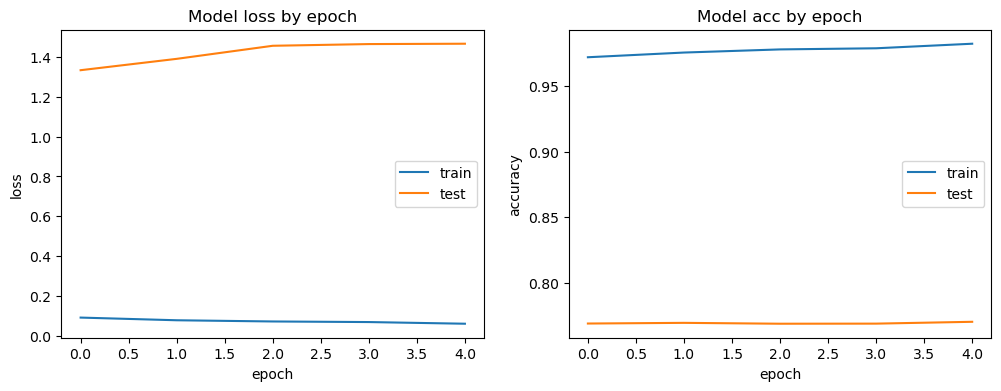

In [63]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tloss)
plt.plot(tvalloss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

   

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [33]:

y_test_original=y_test
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original, test_pred_original)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original, test_pred_original)))

Précision de la prédiction: 76.92534149788037 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.38      0.48      0.42       643
          40       0.61      0.64      0.63       503
          50       0.75      0.80      0.78       319
          60       0.95      0.85      0.90       179
        1140       0.73      0.67      0.70       545
        1160       0.84      0.86      0.85       793
        1180       0.54      0.56      0.55       144
        1280       0.61      0.70      0.65      1002
        1281       0.51      0.51      0.51       408
        1300       0.95      0.91      0.93       993
        1301       0.94      0.90      0.92       162
        1302       0.79      0.78      0.79       514
        1320       0.78      0.76      0.77       664
        1560       0.83      0.79      0.81       993
        1920       0.88      0.91      0.90       832
        1940       0.84      0.7

In [23]:
print(X_text_train.info())
print( y_train.info())
print(X_text_test.info())
print( y_test.info())

<class 'pandas.core.series.Series'>
Index: 67932 entries, 73797 to 58067
Series name: tokenized
Non-Null Count  Dtype 
--------------  ----- 
67932 non-null  object
dtypes: object(1)
memory usage: 1.0+ MB
None
<class 'pandas.core.series.Series'>
Index: 67932 entries, 73797 to 58067
Series name: prdtypecode
Non-Null Count  Dtype
--------------  -----
67932 non-null  int64
dtypes: int64(1)
memory usage: 1.0 MB
None
<class 'pandas.core.series.Series'>
Index: 16984 entries, 66047 to 51817
Series name: tokenized
Non-Null Count  Dtype 
--------------  ----- 
16984 non-null  object
dtypes: object(1)
memory usage: 265.4+ KB
None
<class 'pandas.core.series.Series'>
Index: 16984 entries, 66047 to 51817
Series name: prdtypecode
Non-Null Count  Dtype
--------------  -----
16984 non-null  int64
dtypes: int64(1)
memory usage: 265.4 KB
None


In [35]:
import pandas as pd
df_test = pd.DataFrame({'tokenized': X_text_test, 'prdtypecode': y_test})
df_test['predict']=test_pred_original
df_test.head()

,tokenized,prdtypecode,predict
66047,"[stabilo, lot, stylos, feutre, film, ohpen, universal, indelebile, rouge, stabilo, stylo, feutre...",2522,2522
29942,"[housse, fauteuil, integrale, elastique, protectrice, vert, marque, homescapes, matiere, coton, ...",1920,1920
58440,"[miroir, sprint, campionnissimo, valet]",2280,2280
55079,"[brisons, glace, cold, hearted, icecrown]",1160,1160
11424,"[little, prince, resine, prince, accueil, table, figurine, ornement, magideal, description, vede...",2060,1280


In [36]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    print(df_test[df_test['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.479005
2280    0.177294
2403    0.096423
2705    0.071540
40      0.040435
Name: proportion, dtype: float64
40    ------    jeux video pour pc et consoles
predict
40      0.640159
10      0.083499
1280    0.037773
2280    0.035785
1160    0.035785
Name: proportion, dtype: float64
50    ------     accesoires jeux video
predict
50      0.802508
40      0.053292
2462    0.034483
1280    0.034483
10      0.009404
Name: proportion, dtype: float64
60    ------    consoles de jeux video
predict
60      0.849162
50      0.061453
2462    0.044693
40      0.022346
2905    0.005587
Name: proportion, dtype: float64
1140    ------    produits derives “geeks” et figurines
predict
1140    0.666055
1280    0.121101
40      0.038532
1160    0.036697
2280    0.025688
Name: proportion, dtype: float64
1160    ------    cartes collectionables
predict
1160    0.860025
10      0.029004
1281    0.023960
1140    0.021438
40      0.016393
Name: proportion, dtype: float64

In [37]:
top5_df = pd.DataFrame({'prdtypecode':y_test_original ,'predict': test_pred_original})

df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
top5_df.head()

,prdtypecode,predict
66047,2522,2522
29942,1920,1920
58440,2280,2280
55079,1160,1160
11424,2060,1280


In [38]:
df_pred = pd.DataFrame()
for c in Lcat:
            s = df_cross.loc[c].sort_values(ascending=False)[:5]
            df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
            df_pred = pd.concat([df_pred, df_temp], ignore_index=True)

In [39]:
df_pred

,Categorie,predict,pourc,predict2,pourc2,predict3,pourc3
0,10,10,0.479005,2280,0.177294,2403,0.096423
1,40,40,0.640159,10,0.083499,1280,0.037773
2,50,50,0.802508,40,0.053292,2462,0.034483
3,60,60,0.849162,50,0.061453,2462,0.044693
4,1140,1140,0.666055,1280,0.121101,40,0.038532
5,1160,1160,0.860025,10,0.029004,1281,0.023960
6,1180,1180,0.555556,1140,0.069444,40,0.055556
7,1280,1280,0.699601,1281,0.065868,1140,0.039920
8,1281,1281,0.512255,1280,0.235294,1180,0.034314
9,1300,1300,0.914401,1280,0.041289,40,0.006042


In [40]:
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.479005,0.040435,0.003110,0.000000,0.012442,0.021773,0.006221,0.017107,0.017107,0.001555,0.000000,0.009331,0.004666,0.003110,0.000000,0.004666,0.009331,0.001555,0.177294,0.096423,0.000000,0.010886,0.003110,0.003110,0.006221,0.071540,0.000000
40,0.083499,0.640159,0.027833,0.003976,0.023857,0.035785,0.005964,0.037773,0.021869,0.003976,0.000000,0.000000,0.000000,0.000000,0.003976,0.000000,0.001988,0.001988,0.035785,0.027833,0.017893,0.001988,0.000000,0.001988,0.000000,0.019881,0.001988
50,0.009404,0.053292,0.802508,0.003135,0.009404,0.003135,0.000000,0.034483,0.009404,0.006270,0.000000,0.009404,0.003135,0.006270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.003135,0.003135,0.000000,0.006270,0.000000,0.003135
60,0.000000,0.022346,0.061453,0.849162,0.005587,0.000000,0.000000,0.005587,0.005587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044693,0.000000,0.000000,0.000000,0.000000,0.000000,0.005587
1140,0.020183,0.038532,0.007339,0.000000,0.666055,0.036697,0.012844,0.121101,0.012844,0.003670,0.001835,0.005505,0.007339,0.003670,0.000000,0.000000,0.014679,0.001835,0.025688,0.003670,0.007339,0.007339,0.000000,0.000000,0.000000,0.001835,0.000000
1160,0.029004,0.016393,0.000000,0.000000,0.021438,0.860025,0.003783,0.011349,0.023960,0.001261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003783,0.000000,0.012610,0.003783,0.003783,0.005044,0.000000,0.001261,0.000000,0.002522,0.000000
1180,0.034722,0.055556,0.000000,0.000000,0.069444,0.034722,0.555556,0.034722,0.055556,0.006944,0.000000,0.013889,0.020833,0.000000,0.006944,0.000000,0.020833,0.000000,0.013889,0.020833,0.000000,0.013889,0.006944,0.013889,0.000000,0.020833,0.000000
1280,0.013972,0.016966,0.005988,0.000998,0.039920,0.003992,0.014970,0.699601,0.065868,0.021956,0.001996,0.019960,0.026946,0.004990,0.000998,0.002994,0.015968,0.003992,0.008982,0.003992,0.002994,0.013972,0.001996,0.003992,0.000000,0.000998,0.000998
1281,0.031863,0.024510,0.004902,0.000000,0.007353,0.029412,0.034314,0.235294,0.512255,0.000000,0.004902,0.022059,0.009804,0.004902,0.000000,0.000000,0.009804,0.002451,0.017157,0.002451,0.004902,0.007353,0.000000,0.004902,0.007353,0.019608,0.002451


In [41]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    s=df_cross.loc[c].sort_values(ascending=False)[:5]
    for index, value in s.items():
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")

10    ------    livres
  : 10,  : 47.9 % , livres
  : 2280,  : 17.73 % , magazines
  : 2403,  : 9.64 % , livres et bds
  : 2705,  : 7.15 % , bds et livres
  : 40,  : 4.04 % , jeux video pour pc et consoles
40    ------    jeux video pour pc et consoles
  : 40,  : 64.02 % , jeux video pour pc et consoles
  : 10,  : 8.35 % , livres
  : 1280,  : 3.78 % , jouets, peluches, puppets
  : 1160,  : 3.58 % , cartes collectionables
  : 2280,  : 3.58 % , magazines
50    ------     accesoires jeux video
  : 50,  : 80.25 % ,  accesoires jeux video
  : 40,  : 5.33 % , jeux video pour pc et consoles
  : 2462,  : 3.45 % , consoles de jeux video et jeux videos
  : 1280,  : 3.45 % , jouets, peluches, puppets
  : 10,  : 0.94 % , livres
60    ------    consoles de jeux video
  : 60,  : 84.92 % , consoles de jeux video
  : 50,  : 6.15 % ,  accesoires jeux video
  : 2462,  : 4.47 % , consoles de jeux video et jeux videos
  : 40,  : 2.23 % , jeux video pour pc et consoles
  : 2905,  : 0.56 % , Jeu En téléchar

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_original, test_pred_original)
print(cm[:10,:10])
print('*************************************************')
print(cm[10:20,10:20])
print('*************************************************')
print(cm[20:,20:])

[[308  26   2   0   8  14   4  11  11   1]
 [ 42 322  14   2  12  18   3  19  11   2]
 [  3  17 256   1   3   1   0  11   3   2]
 [  0   4  11 152   1   0   0   1   1   0]
 [ 11  21   4   0 363  20   7  66   7   2]
 [ 23  13   0   0  17 682   3   9  19   1]
 [  5   8   0   0  10   5  80   5   8   1]
 [ 14  17   6   1  40   4  15 701  66  22]
 [ 13  10   2   0   3  12  14  96 209   0]
 [  5   6   3   0   1   2   4  41   4 908]]
*************************************************
[[146   0   2   2   0   0   0   0   0   0]
 [  0 401   5   1   1   1   7   2   3   0]
 [  1   8 502   6  13   1  25   1  10   6]
 [  0   1  15 783  33   1  62   1   0   0]
 [  0   0  16  20 761   1  24   1   0   0]
 [  0   2   1   3   1 117   3   2   6   2]
 [  0   4  16  37  30   1 784   2   4   4]
 [  0   1   5   5   1   2   9 134   4   0]
 [  0   7   5   1   0   3   1   2 558  95]
 [  1   0   1   0   0   1   0   2 113 622]]
*************************************************
[[ 211    0    0    0    1    1    0]


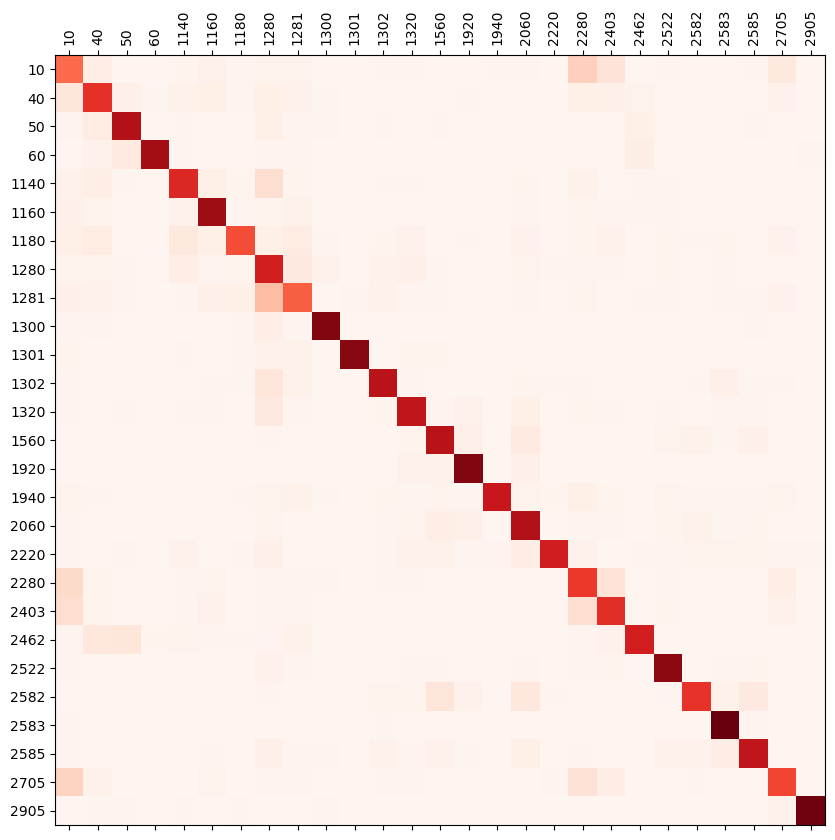

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm_normalized=cm.div(cm.sum(axis=1), axis=0)
cax = ax.matshow(cm_normalized, cmap='Reds')
plt.xticks(range(27),catdict,rotation=90)
plt.yticks(range(27),catdict,rotation=0)
plt.show()

## Etude des catégories 10 ; 2280 ; 2403 ; 2705

In [44]:
df_livres=df_test[df_test['prdtypecode'].isin([10,2280,2403,2705])]
df_livres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3072 entries, 58440 to 46826
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tokenized    3072 non-null   object
 1   prdtypecode  3072 non-null   int64 
 2   predict      3072 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 96.0+ KB


In [35]:
df_livres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3072 entries, 58440 to 46826
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tokenized    3072 non-null   object
 1   prdtypecode  3072 non-null   int64 
 2   predict      3072 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 96.0+ KB


In [45]:

for c in [10,2280,2403,2705]:
    print(c,'   ------   ', catdict[c] )
    print(df_livres[df_livres['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.479005
2280    0.177294
2403    0.096423
2705    0.071540
40      0.040435
Name: proportion, dtype: float64
2280    ------    magazines
predict
2280    0.612514
10      0.137212
2403    0.104281
2705    0.040615
1160    0.017563
Name: proportion, dtype: float64
2403    ------    livres et bds
predict
2403    0.647242
10      0.126951
2280    0.117586
2705    0.022893
1160    0.019771
Name: proportion, dtype: float64
2705    ------    bds et livres
predict
2705    0.576302
10      0.161580
2280    0.105925
2403    0.048474
40      0.023339
Name: proportion, dtype: float64


In [46]:
print(df_livres.info())
df_livres.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3072 entries, 58440 to 46826
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tokenized    3072 non-null   object
 1   prdtypecode  3072 non-null   int64 
 2   predict      3072 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 96.0+ KB
None


,tokenized,prdtypecode,predict
58440,"[miroir, sprint, campionnissimo, valet]",2280,2280
1068,"[dictionnaire, etymologique, roman, derom, second, volume, dictionnaire, tymologique, roman, rom...",2705,10
48464,"[compte, rebours, douze, mois]",2403,1281
22835,"[lot, sas]",2403,2403
37938,"[lot, premiers, tomes, etoiles, hommes, enseignement, christ, maitreya, richard, vitrac, marie, ...",2403,2403


In [47]:
import pandas as pd
from collections import Counter

# Étape 1 : Identifier les 20 mots les plus fréquents
all_words = sum(df_livres['tokenized'].tolist(), [])
global_word_counts = Counter(all_words)
top_20_words = global_word_counts.most_common(20)

# Étape 2 : Calculer le nombre d'occurrences de chaque mot pour chaque classe et globalement
# Initialiser les données pour le DataFrame
data = {"Word": [word for word, count in top_20_words], "Total": [count for word, count in top_20_words]}
class_ids = df_livres['prdtypecode'].unique()

# Calculer les occurrences par classe pour chaque mot
for class_id in class_ids:
    data[class_id] = []
    for word, _ in top_20_words:
        word_count = sum(row.count(word) for row in df_livres[df_livres['prdtypecode'] == class_id]['tokenized'])
        data[class_id].append(word_count)

# Étape 3 : Créer le DataFrame
df_word_counts = pd.DataFrame(data)
df_word_counts.set_index("Word", inplace=True)

# Afficher le DataFrame
print(df_word_counts)
df_total_livres=df_word_counts


            Total  2280  2705  2403  10
Word                                   
lot           426     0     0   426   0
rsquo         369     0   369     0   0
vie           231    33   151    29  18
livres        221     5    13   189  14
monde         179    54   106    14   5
tome          170     6    58    66  40
france        160    73    35    33  19
livre         157     3    83    34  37
cette         149     3   142     2   2
histoire      148    24    77    28  19
temps         108     9    74    14  11
paris         102    55    26    15   6
collection    100    10    16    58  16
jean           97    39    21    25  12
homme          97     6    78     6   7
journal        96    66     7    16   7
edition        96     4     9    40  43
bien           95     7    85     2   1
entre          93     6    74     7   6
deux           92    19    54    14   5


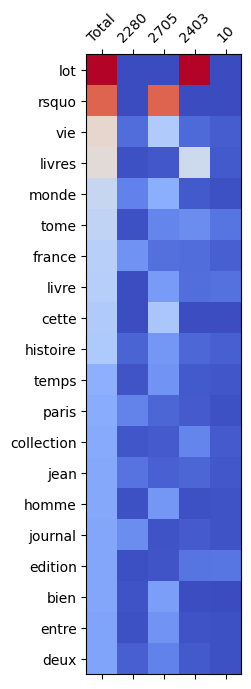

In [48]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:20], cmap = 'coolwarm')
plt.xticks(range(5),(df_total_livres.columns.tolist()),rotation=45)
plt.yticks(range(20),df_total_livres.iloc[0:20].index,rotation=0)
plt.show()


## Etude des catégories 1280,1281

In [49]:
df_jouets=df_test[df_test['prdtypecode'].isin([1280,1281])]

In [50]:
for c in [1280,1281]:
    print(c,'   ------   ', catdict[c] )
    print(df_jouets[df_jouets['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

1280    ------    jouets, peluches, puppets
predict
1280    0.699601
1281    0.065868
1140    0.039920
1320    0.026946
1300    0.021956
Name: proportion, dtype: float64
1281    ------    jeux de societe/cartes
predict
1281    0.512255
1280    0.235294
1180    0.034314
10      0.031863
1160    0.029412
Name: proportion, dtype: float64


In [51]:
import pandas as pd
from collections import Counter

# Étape 1 : Identifier les 20 mots les plus fréquents
all_words = sum(df_jouets['tokenized'].tolist(), [])
global_word_counts = Counter(all_words)
top_20_words = global_word_counts.most_common(20)

# Étape 2 : Calculer le nombre d'occurrences de chaque mot pour chaque classe et globalement
# Initialiser les données pour le DataFrame
data = {"Word": [word for word, count in top_20_words], "Total": [count for word, count in top_20_words]}
class_ids = df_jouets['prdtypecode'].unique()

# Calculer les occurrences par classe pour chaque mot
for class_id in class_ids:
    data[class_id] = []
    for word, _ in top_20_words:
        word_count = sum(row.count(word) for row in df_jouets[df_jouets['prdtypecode'] == class_id]['tokenized'])
        data[class_id].append(word_count)

# Étape 3 : Créer le DataFrame
df_word_counts = pd.DataFrame(data)
df_word_counts.set_index("Word", inplace=True)

# Afficher le DataFrame
df_word_counts
df_total_livres=df_word_counts
df_word_counts

,Total,1280,1281
Word,,,
enfants,1350,940,410
jouet,594,445,149
jouets,593,435,158
bebe,546,416,130
taille,529,423,106
haute,432,337,95
jeu,415,184,231
couleur,372,289,83
toy,372,290,82


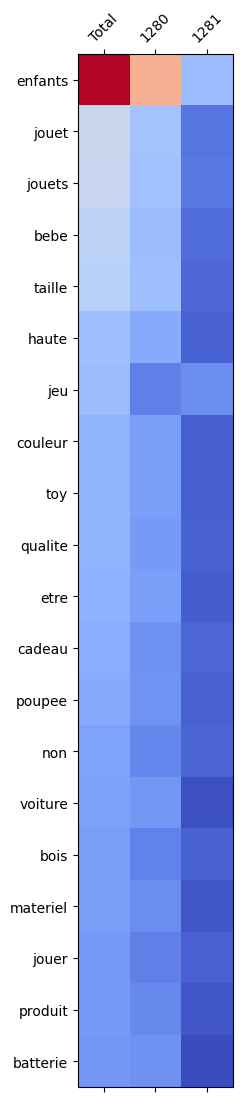

In [52]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:20], cmap = 'coolwarm')
plt.xticks(range(3),(df_total_livres.columns.tolist()),rotation=45)
plt.yticks(range(20),df_total_livres.iloc[0:20].index,rotation=0)
plt.show()